# Lights model tutorial

In [1]:
%reset -f
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from tick.plot import plot_point_process
from lights.simulation import SimuJointLongitudinalSurvival
from lights.base.utils import heatmap, annotate_heatmap, gompertz_pdf, \
                              gompertz_survival, visualize_vect_learning
from sklearn.model_selection import ShuffleSplit
from lifelines.utils import concordance_index as c_index_score
from IPython.display import Markdown, display
from scipy.stats import beta
from matplotlib import rc
rc('text', usetex=True)

def printmd(string):
    display(Markdown(string))

## Generate data

In [2]:
seed = 321
n_long_features = 5
simu = SimuJointLongitudinalSurvival(seed=seed, n_long_features=n_long_features)
X, Y, T, delta = simu.simulate()

printmd("\nLevel of censoring: **%.2f%%**" % (100*(1 - delta.mean())))

-----------------------------------------------------------
Launching simulation using SimuJointLongitudinalSurvival...
Done simulating using SimuJointLongitudinalSurvival in 5.85e+00 seconds.



Level of censoring: **38.90%**

### Visualize parameter vectors
We generate survival times with a risk model of the form
$$\begin{align*}
\lambda_i(t|G_i = k) &= \lambda_0(t) \exp \Big\{ x_i^\top \xi + \sum_{l=1}^L \gamma_{k,1}^l (\beta_{k,1}^l + \beta_{k,2}^l t + b_{i,1}^l + b_{i,2}^l t) + (\gamma_{k,2,1}^l b_{i,1}^l + \gamma_{k,2,2}^l b_{i,2}^l) + \gamma_{k,3}^l (\beta_{k,2}^l + b_{i,2}^l) \Big\} \\
&= \lambda_0(t) \exp \big\{ \iota_{i,k,1} + \iota_{i,k,2} t \big\}
\end{align*}$$

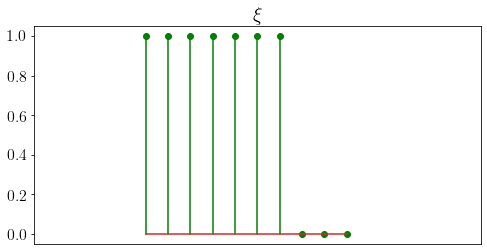

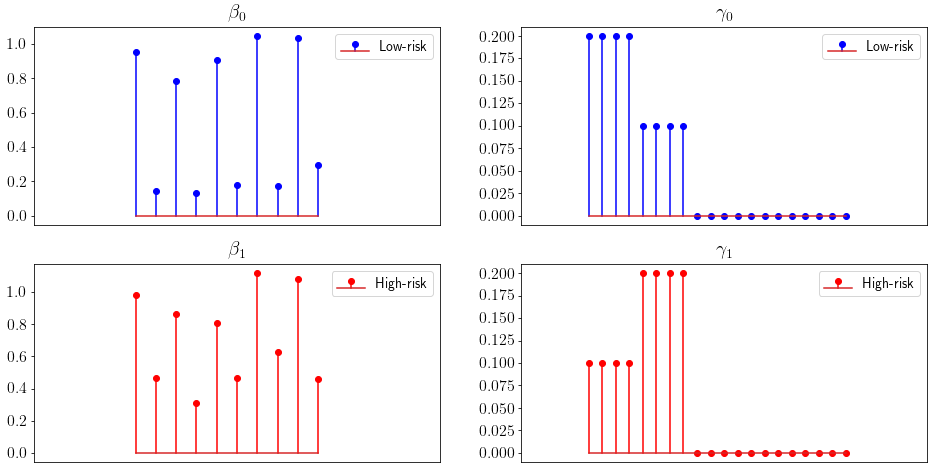

In [3]:
xi, betas, gammas = simu.time_indep_coeffs, simu.fixed_effect_coeffs, simu.asso_coeffs

fig = plt.figure(figsize=(8, 4))
fontsize = 16
ax = fig.add_subplot(111)
ax.stem(xi, linefmt='g-', markerfmt='go')
ax.set_xlim([-5, len(xi) + 5])
ax.set_title(r"$\xi$", fontsize=fontsize+4)
plt.yticks(fontsize=fontsize)
plt.tick_params(axis='x', bottom=False, labelbottom=False)
plt.show()

fig = plt.figure(figsize=(16, 8))
names, colors, labels = ['beta', 'gamma'], ['b', 'r'], ['Low-risk', 'High-risk']
j = 1
for k in [0, 1]:
    for i, vectors in enumerate([betas, gammas]):
        name = names[i]
        ax = fig.add_subplot(2,2,j)
        j += 1
        ax.stem(vectors[k], linefmt='%s-' % colors[k], 
                markerfmt='%so' % colors[k], label=labels[k])
        ax.set_xlim([-5, len(vectors[k]) + 5])
        ax.set_title(r"$\%s_%s$" % (name, k), fontsize=fontsize+4)
        plt.yticks(fontsize=fontsize)
        plt.tick_params(axis='x', bottom=False, labelbottom=False)
        plt.legend(fontsize=fontsize-2)
plt.show()

### Visualize simulated times

We choose a Gompertz distribution for the baseline, that is
$$\lambda_0(t) = \kappa_1 \kappa_2 \exp(\kappa_2t)$$
with $\kappa_1 > 0$ and $\kappa_2 \in R$ the scale and shape parameters respectively.

kappa_1=0.001, kappa_2=0.1


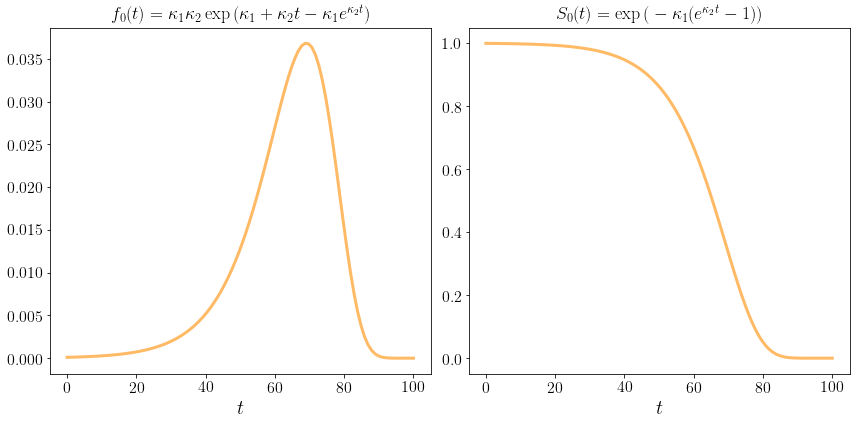

In [4]:
scale, shape = simu.scale, simu.shape
print("kappa_1=%s, kappa_2=%s" % (scale, shape))

fig = plt.figure(figsize=(12, 6))
# Density function plot
ax = fig.add_subplot(121)
t = np.linspace(0, 100, 100)
ax.plot(t, gompertz_pdf(t, shape, scale), '-', color='darkorange', lw=3, alpha=0.6)
plt.xlabel(r"$t$", fontsize=fontsize+4)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.title(r"$f_0(t) = \kappa_1 \kappa_2 \exp \big(\kappa_1 + \kappa_2 t -\kappa_1 e^{\kappa_2 t}\big)$", 
          size=fontsize+2)

# Survival function plot
ax = fig.add_subplot(122)
t = np.linspace(0, 100, 100)
ax.plot(t, gompertz_survival(t, shape, scale), '-', color='darkorange', lw=3, alpha=0.6)
plt.xlabel(r"$t$", fontsize=fontsize+4)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.title(r"$S_0(t) = \exp \big(-\kappa_1 (e^{\kappa_2 t} - 1) \big)$", size=fontsize+2)

fig.tight_layout()
plt.show()

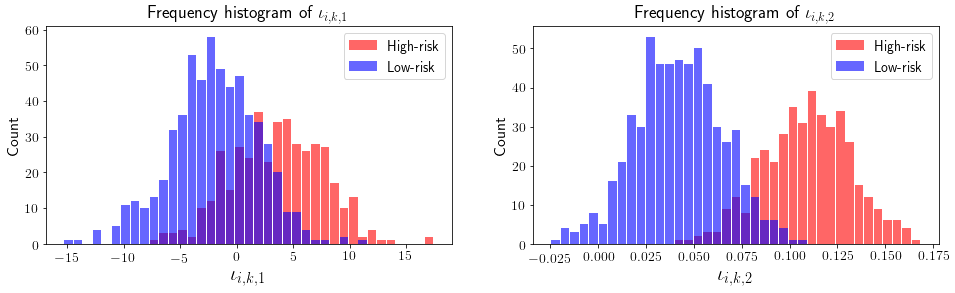

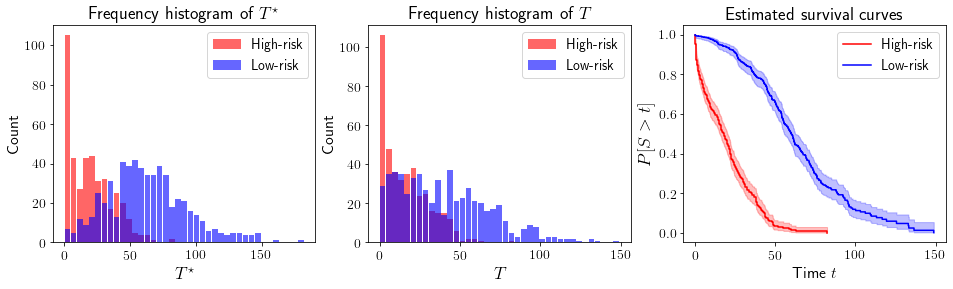

In [5]:
fig = plt.figure(figsize=(16, 4))
iotas = simu.iotas
for i in [1, 2]:
    ax = fig.add_subplot(1,2,i)
    iota_0i, iota_1i = iotas[i]
    all_iota = list(iota_0i) + list(iota_1i)
    mini, maxi = min(all_iota), max(all_iota)
    bins = np.linspace(mini, maxi, 40)
    kwargs = dict(bins=bins, alpha=0.6, rwidth=0.9)
    plt.hist(iota_1i, **kwargs, color='r', label='High-risk')
    plt.hist(iota_0i, **kwargs, color='b', label='Low-risk')
    plt.xlabel(r"$\iota_{i,k,%s}$" % i, size=fontsize + 5)
    plt.ylabel("Count", size=fontsize)
    plt.legend(fontsize=fontsize-2)
    ax.tick_params(labelsize=fontsize-2)
    plt.title("Frequency histogram of " + r'$\iota_{i,k,%s}$' % i, size=fontsize+2)
plt.show()

fig = plt.figure(figsize=(16, 4))
G = simu.latent_class
T_star = simu.event_times
times, labels = [T_star, T], ['T^\star', 'T']
for i in [0, 1]:
    ax = fig.add_subplot(1,3,i+1)
    df = pd.DataFrame(data={"time": times[i], "group": G})
    bins = np.linspace(0, times[i].max(), 40)
    kwargs = dict(bins=bins, alpha=0.6, rwidth=0.9)
    plt.hist(df.loc[df.group == 1, 'time'], **kwargs, color='r', label='High-risk')
    plt.hist(df.loc[df.group==0, 'time'], **kwargs, color='b', label='Low-risk')
    plt.legend(fontsize=fontsize-2)
    plt.xlabel(r'$%s$' % labels[i], size=fontsize+2)
    plt.ylabel("Count", size=fontsize)
    ax.tick_params(labelsize=fontsize-2)
    plt.title("Frequency histogram of " + r'$%s$' % labels[i], size=fontsize+2)

# Kaplan Meier estimation of survival curves
kmf = KaplanMeierFitter()
ax = plt.subplot(133)
kmf.fit(T[G == 1], delta[G == 1], label="High-risk").plot(ax=ax, c='r')
kmf.fit(T[G == 0], delta[G == 0], label="Low-risk").plot(ax=ax, c='b')
plt.legend(fontsize=fontsize-2)
plt.xlabel('Time $t$', size=fontsize)
plt.ylabel(r'$P[S > t]$', size=fontsize+2)
plt.title("Estimated survival curves", size=fontsize+2)
ax.tick_params(labelsize=fontsize-2)
plt.show()

### Visualize longitudinal processes for two subjects randomly chosen

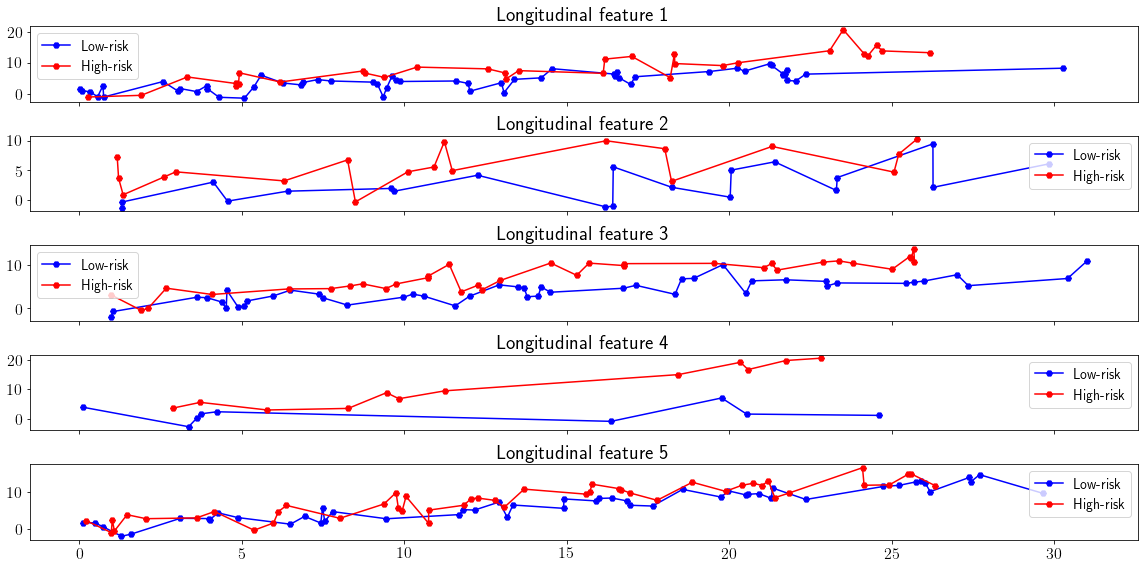

In [6]:
np.random.seed(seed)
fig = plt.figure(figsize=(16, 8))
ax0 = plt.subplot(n_long_features,1,1)
colors, labels = ['b', 'r'], ['Low-risk', 'High-risk']
for k in [0, 1]:
    idx = np.random.choice(Y[G == k].index)
    Y_i = Y.loc[idx, :]
    label, color = labels[k], colors[k]
    for l in range(1, n_long_features + 1):
        Y_il = Y_i["long_feature_%s" % l]
        ax = plt.subplot(n_long_features,1 ,l , sharex=ax0)
        Y_il.plot(label=label, color=color, marker='H')
        ax.set_title("Longitudinal feature %s" % l, fontsize=fontsize+4)
        plt.xticks(fontsize=fontsize), plt.yticks(fontsize=fontsize)
        plt.legend(fontsize=fontsize-2)
fig.tight_layout()
plt.show()

### Visualize Hawkes Processes used to generate time measurements of longitudinal data for the previous high-risk subject

For a subject $i$, times $\{t_{ij}^l\}_{j \geq 1}$ for processes $l=1, \ldots, L$ are simulated using a multivariate Hawkes process $N_{it} = [N_{it}^1 \cdots N_{it}^L]$ with $t \geq 0$ and $N_{it}^l = \sum_{j \geq 1} 1_{\{t_{ij}^l \leq t\}}$. The process $N_{it}$ is a multivariate counting process, whose components $N_{it}^l$ have intensities
$$\lambda_i^l(t) = \Upsilon_{l} + \sum_{l'=1}^L \sum_{j \geq 1} A_{ll'} \upsilon \exp\big(-\upsilon(t - t_{ij}^{l'}) \big)$$
for $l=1, \ldots, L$.

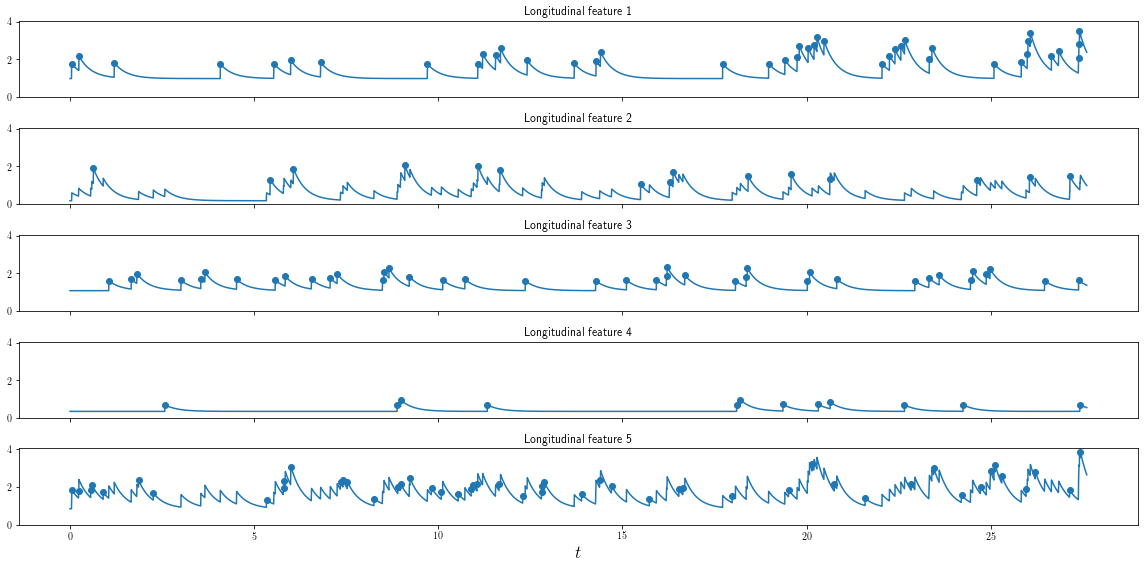

In [7]:
hawkes = simu.hawkes
hawkes_i = hawkes[idx]
adjacency = hawkes_i.adjacency

# need to reset hawkes to track intensity
hawkes_i.reset()
dt = 0.01
hawkes_i.track_intensity(dt)
hawkes_i.simulate()

fig, ax = plt.subplots(n_long_features, 1, figsize=(16, 8), sharex=True, sharey=True)
long_features_names = ["Longitudinal feature %s" % (l + 1) for l in range(n_long_features)]
plot_point_process(hawkes_i, n_points=50000, ax=ax, node_names=long_features_names)
fig.tight_layout()

The matrix $A = [A_{ll'}]_{1 \leq l,l' \leq L}$ is the adjacency matrix such that $A_{ll'} \geq 0$ quantifies the impact of past measurement time of process $l'$ on the measurement time of process $l$, and $\upsilon \geq 0$ is a memory parameter.

We also plot the density of the law used to simulate $t_i^{max}$, that is
$$t_i^{max} \sim T_i \times \big(1 - \text{Beta}(\nu_1, \nu_2)\big)$$
with $(\nu_1, \nu_2) = (2,5)$, to mimic the fact that in practice, one has access to a reasonable amount of longitudinal data before making a prediction.

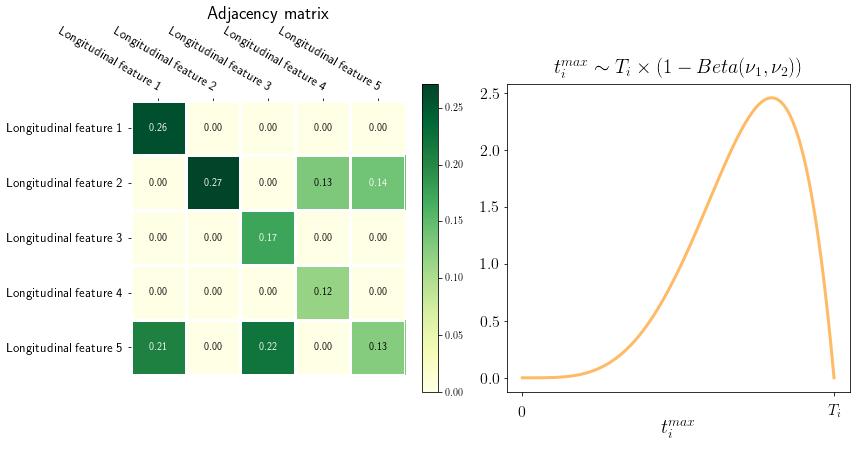

In [8]:
fig = plt.figure(figsize=(12, 6))
# Adjacency matrix
ax = fig.add_subplot(121)
im, cbar = heatmap(adjacency, long_features_names, long_features_names, ax=ax, cmap="YlGn")
texts = annotate_heatmap(im)
plt.title("Adjacency matrix", size=fontsize+2)

# Density of the law for the time up to which one has longitudinal data
ax = fig.add_subplot(122)
a, b = 2, 5
x = np.linspace(beta.ppf(0.0, a, b),
                beta.ppf(1, a, b), 100)
ax.plot(x, beta.pdf(1-x, a, b), '-', color='darkorange', lw=3, alpha=0.6)
labels = ['', r'$0$', r"$T_i$"]
plt.xlabel(r"$t_i^{max}$", fontsize=fontsize+4)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
ax.tick_params(axis='x', pad=10)
plt.title(r"$t_i^{max} \sim T_i \times \big(1 - Beta(\nu_1, \nu_2)\big) $", size=fontsize+4)
plt.locator_params(axis='x', nbins=2)
ax.set_xticklabels(labels)

fig.tight_layout()
plt.show()

# Lights learning

## Initializer illustration

Since our QNMCEM algorithm gives a local minimum, it is clever to choose an initial value $\theta^{(0)}$ close to the final solution $\hat \theta$, so that the number of iterations required to reach convergence is reduced.

The longitudinal submodels parameters $\beta_k^{(0)}$, $D^{(0)}$ and $\phi^{(0)}$ are initialized (like if there is no subgroup ($\beta_0^{(0)} = \beta_{1}^{(0)}$)) using a multivariate linear mixed model (MLMM) with an explicit EM algorithm, being itself initialized with univariates fits (ULMM). Let us test those initializer on a simple example.

### Simulation with no latent subgroups

In [9]:
from lights.init.mlmm import MLMM
from lights.base.base import extract_features
from lights.base.utils import plot_history

# high_risk_rate=0 for no subgroups
simu = SimuJointLongitudinalSurvival(n_samples=200, n_time_indep_features=5,
                                     n_long_features=3, seed=123, high_risk_rate=0)
Y_ = simu.simulate()[1]
# Get true beta parameter
true_beta = simu.fixed_effect_coeffs[0]

-----------------------------------------------------------
Launching simulation using SimuJointLongitudinalSurvival...
Done simulating using SimuJointLongitudinalSurvival in 9.10e-01 seconds.


### MLMM with fixed initialization

For instance $\beta^{(0)}=\textbf{0}$

Launching the solver MLMM...
 n_iter  |   obj    | rel_obj 
       0 |  23132.9 |      inf
       5 |  17118.5 | 8.96e-04
      10 |  17094.6 | 1.57e-04
      15 |  17085.3 | 8.84e-05
      20 |  17079.1 | 6.57e-05
      25 |    17074 | 5.53e-05
      30 |  17069.6 | 4.97e-05
      35 |  17065.5 | 4.65e-05
      40 |  17061.7 | 4.44e-05
      45 |    17058 | 4.32e-05
      50 |  17054.3 | 4.24e-05
      55 |  17050.7 | 4.20e-05
      60 |  17047.2 | 4.18e-05
      65 |  17043.6 | 4.18e-05
      70 |    17040 | 4.19e-05
      75 |  17036.5 | 4.22e-05
      80 |  17032.8 | 4.26e-05
      85 |  17029.2 | 4.31e-05
      90 |  17025.5 | 4.37e-05
      95 |  17021.7 | 4.44e-05
     100 |  17017.9 | 4.51e-05
Done solving using MLMM in 1.78e+01 seconds


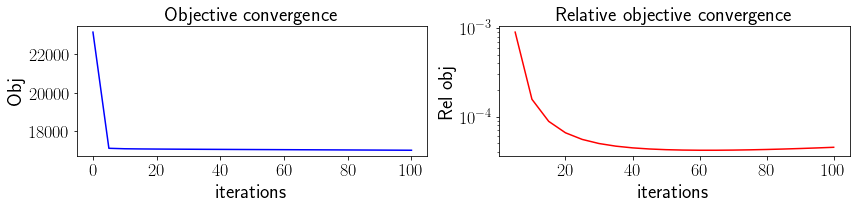

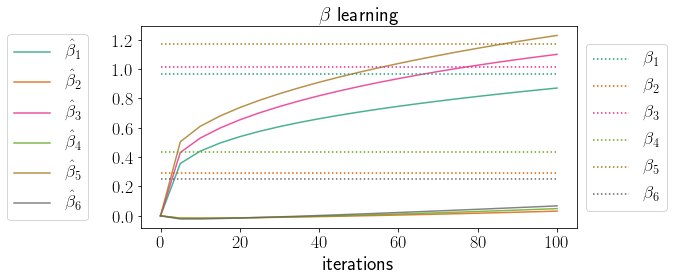

In [10]:
fixed_effect_time_order = 1
tol = 4e-5
mlmm = MLMM(fixed_effect_time_order=fixed_effect_time_order, 
            print_every=5, tol=tol, initialize=False)
# Get design features matrices
extracted_features = extract_features(Y_, fixed_effect_time_order)
# Train the initializer
mlmm.fit(extracted_features)

# Visualize learning
to = len(true_beta)+1
leg1 = [r"$\hat \beta_%s$" % j for j in range(1, to)]
leg2 = [r"$\beta_%s$" % j for j in range(1, to)]
visualize_vect_learning(mlmm, "fixed_effect_coeffs", r"$\beta$", true_beta, leg1, leg2)

### MLMM with ULMM initialization

<span style="color:crimson">**Convergence is faster, and the estimation much better**</span>

Launching the solver MLMM...
Launching the solver ULMM...
Done solving using ULMM in 2.54e+00 seconds
 n_iter  |   obj    | rel_obj 
       0 |  16877.6 |      inf
       5 |  16807.3 | 1.81e-04
      10 |  16795.8 | 1.16e-04
      15 |  16788.1 | 7.83e-05
      20 |  16782.8 | 5.33e-05
Done solving using MLMM in 7.46e+00 seconds


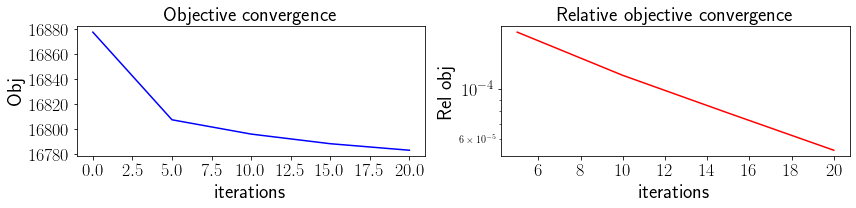

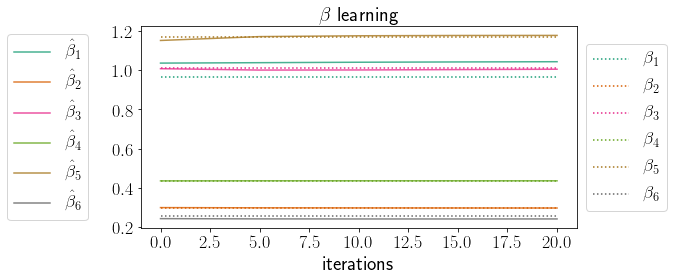

In [11]:
mlmm = MLMM(fixed_effect_time_order=fixed_effect_time_order, 
            print_every=5, tol=tol, initialize=True)
extracted_features = extract_features(Y_, fixed_effect_time_order)
mlmm.fit(extracted_features)
visualize_vect_learning(mlmm, "fixed_effect_coeffs", r"$\beta$", true_beta, leg1, leg2)

## Data splitting

In [12]:
# Split data into training and test sets 
test_size = .3  # proportion of data used for testing
rs = ShuffleSplit(n_splits=1, test_size=test_size, random_state=0)

for train_index, test_index in rs.split(X):
    X_test = X[test_index]
    Y_test = Y.iloc[test_index, :]
    T_test = T[test_index]
    delta_test = delta[test_index]

    X = X[train_index]
    Y = Y.iloc[train_index, :]
    T = T[train_index]
    delta = delta[train_index]  
    
print("%d%% for training, %d%% for testing." 
      % ((1 - test_size) * 100, test_size * 100))

70% for training, 30% for testing.


## Training 

In [13]:
## Choose parameters ##
tol = 1e-6            # tolerance for the convergence stopping criterion 
eta = 0.3             # parameter controlling the trade-off between l1 
                      # and l2 regularization in the elasticNet
gamma_chosen = '1se'  # way to select l_elasticNet_chosen: '1se' or 'min'
warm_start = True     # at each L-BGFS-B iteration, reset beta to 0 or take 
                      # the previous value 
grid_size = 30        # grid size for the cross validation procedure
metric = 'C-index'    # cross-validation metric: 'log_lik' or 'C-index'

# declare learner here        

## Cross-validation ##

## Run selected model with l_elasticNet_chosen ##

# run final fit here

## Prediction

In [14]:
## Obtain the marker vector on test set ##

# prediction here

#c_index = c_index_score(Y_test, marker, delta_test)
#c_index = max(c_index, 1 - c_index)

print("Done predicting on test set.")
#print("C-index : %.2f" % c_index)

Done predicting on test set.


## Figures

### Learning curves

### Convergence

### Beta coefficients